# Post-processing workflow

## 1) Threshold pixels in detected masks

As we use a softmax function in the last layer of UNet, we obtain a 3D mask where each channel (3rd dimension) corresponds to a class, and each pixel to a probability. We don't need the 3rd channel (probabilities of background class), and for the 2 first channels we need to threshold the pixel values in order to have binary masks (only 0s or 1s). 

We choose as threshold `0.8*255` (255 is the max pixel value in uint8 pixel format). This helps clean the pixels whit too low probability of class.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import rgb2gray
from skimage import io
from matplotlib import patches

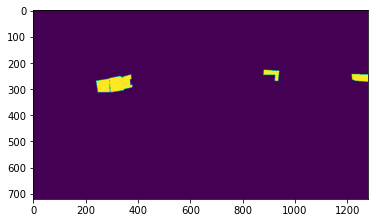

In [2]:
original = io.imread('../chronsite_images/masks/Batch2__BioSAV_BIofiltration_18mois_05frame3389_formworks.png')
plt.imshow(original)

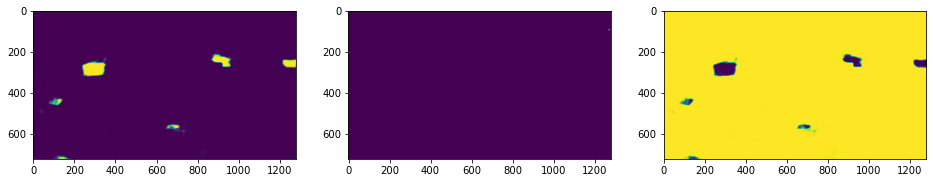

In [3]:
detected = io.imread('../inference/pr_mask.png')

plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.imshow(detected[...,0])
plt.subplot(132)
plt.imshow(detected[...,1])
plt.subplot(133)
plt.imshow(detected[...,2])

In [4]:
def threshold_image(image, threshold=128):
    # grab the image dimensions
    h = image.shape[0]
    w = image.shape[1]
    thresholded_image = image.copy()
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            thresholded_image[y, x] = 255 if image[y, x] >= threshold else 0     
    # return the thresholded image
    return thresholded_image

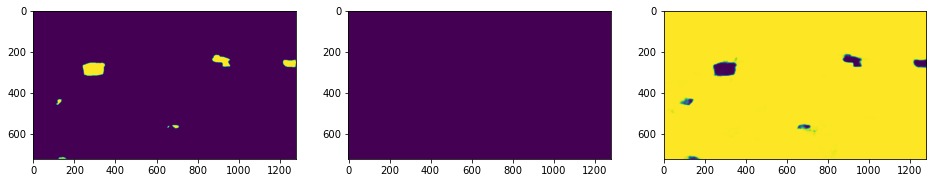

In [5]:
T = 204
formworks = threshold_image(detected[...,0], threshold = T)
pumps = threshold_image(detected[...,1], threshold = T)

plt.figure(figsize=(16, 5))
plt.subplot(131)
plt.imshow(formworks)
plt.subplot(132)
plt.imshow(pumps)
plt.subplot(133)
plt.imshow(detected[...,2])

In [6]:
# number of pixels for each pixel value before thresholding
unique, counts = np.unique(detected[...,0], return_counts=True)
print(dict(zip(unique, counts)))

{0: 851686, 1: 36786, 2: 5696, 3: 2685, 4: 1621, 5: 1058, 6: 780, 7: 514, 8: 477, 9: 349, 10: 299, 11: 255, 12: 211, 13: 199, 14: 179, 15: 163, 16: 162, 17: 155, 18: 120, 19: 146, 20: 126, 21: 141, 22: 118, 23: 103, 24: 86, 25: 97, 26: 84, 27: 106, 28: 75, 29: 92, 30: 74, 31: 77, 32: 84, 33: 73, 34: 70, 35: 39, 36: 58, 37: 59, 38: 57, 39: 60, 40: 49, 41: 56, 42: 46, 43: 44, 44: 37, 45: 53, 46: 50, 47: 32, 48: 24, 49: 46, 50: 43, 51: 37, 52: 47, 53: 42, 54: 33, 55: 40, 56: 36, 57: 34, 58: 50, 59: 27, 60: 28, 61: 33, 62: 34, 63: 46, 64: 22, 65: 36, 66: 28, 67: 28, 68: 19, 69: 41, 70: 18, 71: 26, 72: 37, 73: 27, 74: 22, 75: 13, 76: 29, 77: 31, 78: 31, 79: 30, 80: 32, 81: 25, 82: 19, 83: 22, 84: 32, 85: 35, 86: 30, 87: 25, 88: 38, 89: 28, 90: 42, 91: 23, 92: 27, 93: 30, 94: 34, 95: 32, 96: 25, 97: 30, 98: 21, 99: 38, 100: 11, 101: 22, 102: 29, 103: 19, 104: 28, 105: 16, 106: 20, 107: 22, 108: 12, 109: 24, 110: 19, 111: 15, 112: 27, 113: 21, 114: 22, 115: 16, 116: 15, 117: 20, 118: 18, 119:

In [7]:
# number of pixels for each pixel value after thresholding
unique, counts = np.unique(formworks, return_counts=True)
print(dict(zip(unique, counts)))

{0: 909844, 255: 11756}


## 2) Find polygon contours

We want to find the number of separate objects detected by a segmentation model. For each channel (i.e. each class) in the output mask, we find the contours of all distinct objects, and then we compute their area so we can eliminate the too small predictions (corresponding to prediction artefacts / errors).

In [130]:
#essai = list(map(int, contours_formworks))
essai = [*map(int, contours_formworks)]
essai

TypeError: only size-1 arrays can be converted to Python scalars

In [74]:
contours_formworks = measure.find_contours(formworks, 1)
contours_pumps = measure.find_contours(pumps, 1)

contours_formworks = [x.round(0).tolist() for x in np.array(contours_formworks)]
contours_pumps = [x.round(0).tolist() for x in np.array(contours_pumps)]

In [ ]:
contours_formworks = [list(map(list, set(map(tuple, x)))) for x in contours_formworks]
contours_pumps = [list(map(list, set(map(tuple, x)))) for x in contours_pumps]

In [94]:
test

[[270.99607843, 939.0],
 [270.99607843, 938.0],
 [270.99607843, 937.0],
 [270.99607843, 936.0],
 [270.99607843, 935.0],
 [270.99607843, 934.0],
 [270.99607843, 933.0],
 [270.99607843, 932.0],
 [270.99607843, 931.0],
 [270.99607843, 930.0],
 [270.0, 929.00392157]]

In [88]:
test3 = [list(map(list, set(map(tuple, x)))) for x in test2]
test3

[]

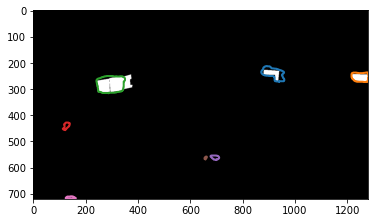

In [102]:
fig, ax = plt.subplots()
ax.imshow(original, cmap=plt.cm.gray)

for contour in contours_formworks:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    #p = patches.Polygon(list(zip(contour[:,1],contour[:,0])), alpha=0.5)
    #ax.add_patch(p)

In [103]:
len(contours_formworks)

7

In [97]:
# to compute the area we need to convert polygons to shapely
from shapely.geometry import Polygon
for contour in contours_formworks:
    poly = Polygon(contour)
    print(poly.area)

3016.5
2011.5
6054.0
425.5
395.0
56.5
267.5


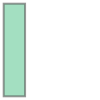

In [105]:
poly.envelope

$\rightarrow$ We will keep only the polygons with area > 300 square pixels (arbitrary).

## 3) Compute concave hull

The concave hull, or alpha shape, allows to smoothen the polygon shape so that it is less complex (and more realistic in an object detection task).

In [22]:
!pip install descartes
!pip install fiona

In [41]:
import shapely
from shapely import ops
from scipy.spatial import Delaunay
import math
from descartes import PolygonPatch
import fiona
from matplotlib.collections import LineCollection
import random


def alpha_shape(polygon, nb_points=500, alpha=500, plot=False):
    """
    Computes the alpha shape (concave hull smoothing) of a set of shapely Points, using
    a Delaunay triangulation algorithm.

    The idea is to build triangles between all points (i.e. computing a convex hull), and 
    to remove triangle lines longer than 1/alpha.
    Therefore, the higher the alpha, the higher the precision (you eliminate smaller 
    triangles and get closer to the original polygon shape). The nb of points inside of 
    the polygon is important as well: the higher the nb of points, the smaller the triangles, 
    and the higher alpha will have to be to augment the precision of the concave hull.

    => All in all, the value of alpha and the nb of points should depend on the 
    size of the original polygon! [TODO: automate the choice of nb_points and alpha]
    
    Arguments:
        nb_points: nb of points to generate inside of polygon
        alpha: alpha value to influence the gooeyness of the border
        plot: set to True to plot the Delaunay triangles and alpha shape polygon
    Returns:
        concave_hull_poly: new shapely Polygon object
        concave_hull_coords: list of point coordinates (as np array)
    """
    
    # generate points inside polygon for alpha shape / Delaunay triangulation
    points = generate_points_in_polygon(nb_points, polygon)
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull

    # Delaunay triangulation
    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - 
        triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - 
        triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - 
        triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)] # filter too large triangles

    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    
    # Recreate new edge point coordinates and new polygon (concave hull)
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis=0).tolist()
    m = shapely.geometry.MultiLineString(edge_points)
    triangles = list(shapely.ops.polygonize(m))
    concave_hull_poly = shapely.ops.cascaded_union(triangles)
    
    # get rounded coordinates of concave hull polygon
    x,y = concave_hull_poly.exterior.coords.xy
    x = [round(i,0) for i in x]
    y = [round(i,0) for i in y]
    concave_hull_coords = list(zip(x,y))
    concave_hull_coords = list(dict.fromkeys(concave_hull_coords))

    # plot if requested
    if plot:
        lines = LineCollection(edge_points)
        plt.figure(figsize=(8,8))
        plt.title('Alpha={0} Delaunay triangulation'.format(alpha))
        plt.gca().add_collection(lines)
        delaunay_points = np.array([point.coords[0] for point in points])
        x_rand = [poly_r.coords[0][0] for poly_r in points]
        y_rand = [poly_r.coords[0][1] for poly_r in points]
        plt.plot(delaunay_points[:,0], delaunay_points[:,1], 'o', color='#f16824')
        _ = plot_polygon(concave_hull_poly)
        _ = plt.plot(x_rand,y_rand,'o', color='#f16824')

    return concave_hull_poly, concave_hull_coords

def generate_points_in_polygon(number, polygon):
    """
    Helper fuction for alpha_shape.
    Generates a chosen nb of random points inside of a random polygon.
    Returns: a list of shapely Point objects.
    """
    list_of_points = []
    minx, miny, maxx, maxy = polygon.bounds
    counter = 0
    while counter < number:
        pnt = shapely.geometry.Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            list_of_points.append(pnt)
            counter += 1
    return list_of_points

def plot_polygon(polygon):
    """
    Helper fuction for alpha_shape.
    Plots a shapely polygon in a matplotlib figure.
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    margin = 0

    x_min, y_min, x_max, y_max = polygon.bounds

    ax.set_xlim([x_min-margin, x_max+margin])
    ax.set_ylim([y_min-margin, y_max+margin])
    patch = PolygonPatch(polygon, fc='#999999', ec='#000000', fill=True, zorder=-1)
    ax.add_patch(patch)
    return fig

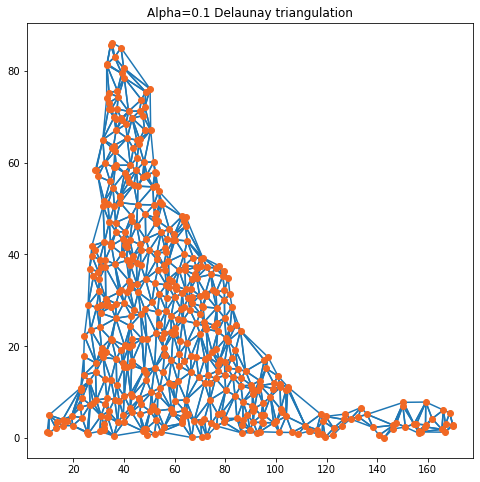

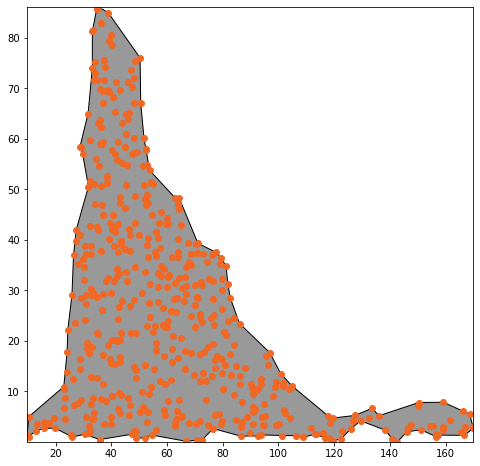

In [42]:
concave_hull_poly, concave_hull_coords = alpha_shape(poly, alpha=0.1, plot=True)

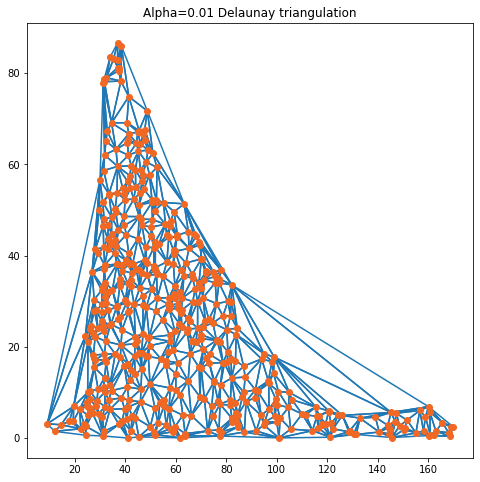

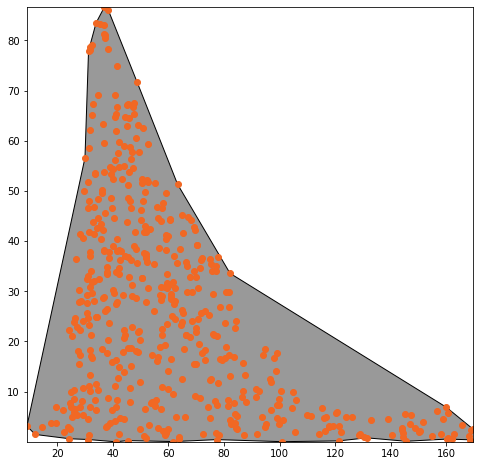

In [56]:
concave_hull_poly, concave_hull_coords = alpha_shape(poly, alpha=0.01, plot=True)

In [57]:
len(contours[0])

401

In [58]:
len(concave_hull_coords)

25

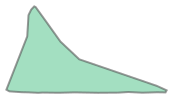

In [59]:
concave_hull_poly

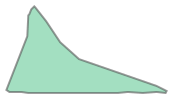

In [60]:
Polygon(concave_hull_coords)

## 4) Save in COCO label format

Last, we need to save the coordinates of each polygon in a JSON dictionary respecting the COCO format.

In [108]:
# let's take a look at the example

import json
with open('../inference/coco_test.json') as f:
    example = json.load(f)

In [120]:
# this class allows to display a json file in a collapsible format, easier to read

import uuid
from IPython.core.display import display, HTML
import json

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())
        # This line is missed out in most of the versions of this script across the web, it is essential for this to work interleaved with print statements
        #self._ipython_display_()
        
    def _ipython_display_(self):
        display(HTML('<div id="{}" style="height: auto; width:100%;"></div>'.format(self.uuid)))
        display(HTML("""<script>
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
          renderjson.set_show_to_level(1)
          document.getElementById('%s').appendChild(renderjson(%s))
        });</script>
        """ % (self.uuid, self.json_str)))

RenderJSON(example)

In [122]:
# pprint also allows to print JSON in a readable format - if file isn't too long
import pprint
#pprint.pprint(example)

In [ ]:
json_template = {"categories":[{"Supercategory": "none",
                                  "name": "People",
                                  "id": 1},
                                 {"Supercategory": "none",
                                  "name": "Mixer_truck",
                                  "id": 2},
                                 {"Supercategory": "none",
                                  "name": "Vertical_formwork",
                                  "id": 3},
                                 {"Supercategory": "none",
                                  "name": "Concrete_pump_hose",
                                  "id": 4}],
                  "info": {"description": "Chronsite test dataset",
                           "year": 2020},
                  "licenses": [],
                  "images": [{"file_name": "xx.jpg",
                              "id": 33,
                              "height": 1024,
                              "width": 1280}],
                  'annotations': [{'area': 5040,
                                   'bbox': [980, 696, 60, 84],
                                   'category_id': 3,
                                   'id': 630,
                                   'image_id': 33,
                                   'iscrowd': 0,
                                   'segmentation': [[990, 700, 1007, 696]]
                                  }]}

## Full post-processing workflow

1) We threshold pixels for each class in the predicted mask\
2) We run contour detection on the 2 first channels to identify polygons\
3) we apply alpha shape triangulation to smooth them\
4) we store the polygon coordinates in a dictionary and save it as JSON

In [67]:
mask_path = 'mask.png'
pr_mask = skimage.io.imread(mask_path)
grayscale = rgb2gray(pr_mask)
contours = measure.find_contours(grayscale, 0.1)

pr_polygons = {}
for i, contour in enumerate(contours):
    _, concave_hull_coords = alpha_shape(Polygon(contour), alpha=0.01)
    pr_polygons[f'polygon_{i}'] = concave_hull_coords
pr_polygons

{'polygon_0': [(13.0, 0.0),
  (14.0, 0.0),
  (15.0, 0.0),
  (16.0, 0.0),
  (17.0, 0.0),
  (18.0, 0.0)],
 'polygon_1': [(176.0, 0.0), (175.0, 0.0), (173.0, 0.0)],
 'polygon_2': [(191.0, 0.0), (192.0, 0.0)],
 'polygon_3': [(334.0, 0.0),
  (333.0, 0.0),
  (335.0, 0.0),
  (337.0, 0.0),
  (338.0, 0.0),
  (339.0, 0.0),
  (336.0, 0.0)],
 'polygon_4': [(468.0, 0.0),
  (470.0, 1.0),
  (471.0, 0.0),
  (470.0, 0.0),
  (469.0, 0.0)],
 'polygon_5': [(470.0, 2.0)],
 'polygon_6': [(484.0, 0.0),
  (483.0, 0.0),
  (482.0, 0.0),
  (481.0, 0.0),
  (480.0, 0.0),
  (479.0, 0.0),
  (478.0, 0.0),
  (476.0, 0.0),
  (477.0, 1.0)],
 'polygon_7': [(496.0, 0.0), (495.0, 0.0), (494.0, 0.0)],
 'polygon_8': [(509.0, 0.0),
  (508.0, 0.0),
  (507.0, 0.0),
  (510.0, 1.0),
  (511.0, 0.0),
  (510.0, 0.0)],
 'polygon_9': [(519.0, 0.0), (520.0, 0.0), (521.0, 0.0)],
 'polygon_10': [(747.0, 0.0)]}

In [69]:
import json
with open('pr_polygons.json', 'w') as f:
    json.dump(pr_polygons, f)